# Quantization of DWT-ransformed audio signals

In [1]:
import sounddevice as sd
import pywt
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pylab

## Capture an audio sequence

In [2]:
def plot(y, xlabel='', ylabel='', title='', marker='.'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, num=len(y))
    ax.plot(x, y, marker, markersize=1)
    plt.show(block=False)

In [12]:
fs = 44100
duration = 80000/44100  # seconds
signal = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")
signal = signal.flatten()

Say something!
done


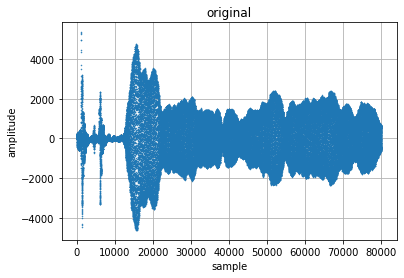

In [13]:
plot(signal, "sample", "amplitude", "original")

## Select a number of levels of the DWT

In [14]:
levels = 3

## Filters selection

In [15]:
#wavelet_name = "haar"
wavelet_name = "db5"
#wavelet_name = "db20"
#wavelet_name = "bior2.2"
#wavelet_name = "rbio2.2"
wavelet = pywt.Wavelet(wavelet_name)

## Define a dead-zone quantizer

In [16]:
def deadzone_quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int)
    return k

def deadzone_dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

## Extract 3 consecutive chunks from the audio sequence

In [17]:
chunk_size = 128
chunk_number = 15
chunk_left = signal[chunk_size * (chunk_number - 1) : chunk_size * chunk_number]
chunk_center = signal[chunk_size * chunk_number : chunk_size * (chunk_number + 1)]
chunk_right = signal[chunk_size * (chunk_number + 1) : chunk_size * (chunk_number + 2)]
chunks = np.concatenate([chunk_left, chunk_center, chunk_right])

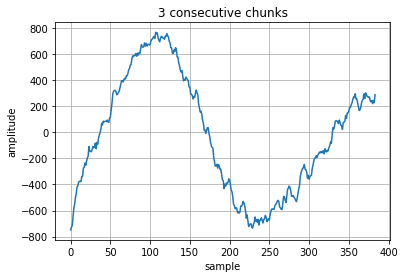

In [18]:
plot(chunks, "sample", "amplitude", "3 consecutive chunks", '-')

## Quantize the chunks in the DWT domain
Each chunk is transformed independently.

In [19]:
quantization_step = 128
def transform_and_quantize(chunk):
    decomposition = pywt.wavedec(chunk, wavelet=wavelet, level=levels, mode="per")
    coefficients, slices = pywt.coeffs_to_array(decomposition)
    quantized_coeffs = deadzone_dequantizer(deadzone_quantizer(coefficients, quantization_step), quantization_step)
    decomposition = pywt.array_to_coeffs(quantized_coeffs, slices, output_format="wavedec")
    reconstructed_chunk = pywt.waverec(decomposition, wavelet=wavelet, mode="per")
    return reconstructed_chunk

rchunk_left = transform_and_quantize(chunk_left)
rchunk_center = transform_and_quantize(chunk_center)
rchunk_right = transform_and_quantize(chunk_right)

## Concatenation of the reconstructed chunks

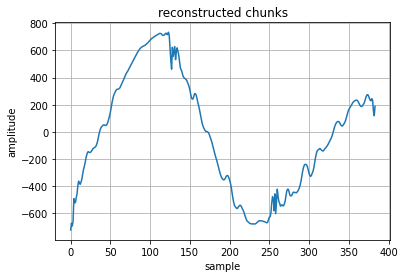

In [20]:
rchunks = np.concatenate([rchunk_left, rchunk_center, rchunk_right])
plot(rchunks, "sample", "amplitude", "reconstructed chunks", '-')

## Reconstruction of the concatenated chunks
This is the ideal reconstruction (ingnoring the first and the last samples of the concatenation).

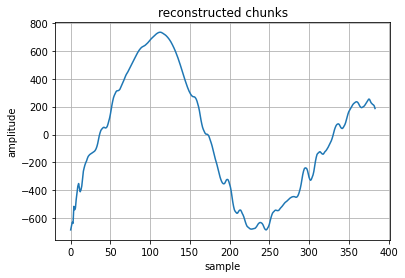

In [22]:
ideal_chunks = transform_and_quantize(chunks)
plot(ideal_chunks, "sample", "amplitude", "reconstructed chunks", '-')

## A solution: use the neighbor samples
To compute the DWT.

In [23]:
number_of_overlaped_samples = 1 << math.ceil(math.log(wavelet.dec_len * levels) / math.log(2))
print("number_of_overlaped_samples =", number_of_overlaped_samples)

number_of_overlaped_samples = 32


### Create an extended chunk that overlaps with the previous and the next one

number of samples overlaped with the previous chunk= 32
number of samples in the current chunk = 128
number of samples overlaped with the next chunk = 32
length of the extended chunk = 192


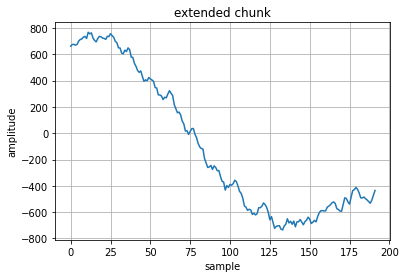

In [25]:
last_samples_left_chunk = chunk_left[chunk_size - number_of_overlaped_samples :]
first_samples_right_chunk = chunk_right[: number_of_overlaped_samples]
extended_chunk = np.concatenate([last_samples_left_chunk, chunk_center, first_samples_right_chunk])
print("number of samples overlaped with the previous chunk=", len(last_samples_left_chunk))
print("number of samples in the current chunk =", len(chunk_center))
print("number of samples overlaped with the next chunk =", len(first_samples_right_chunk))
print("length of the extended chunk =", len(extended_chunk))
plot(extended_chunk, "sample", "amplitude", "extended chunk", '-')

### Transform and quantize the extended chunk

In [26]:
rextended_chunk = transform_and_quantize(extended_chunk)

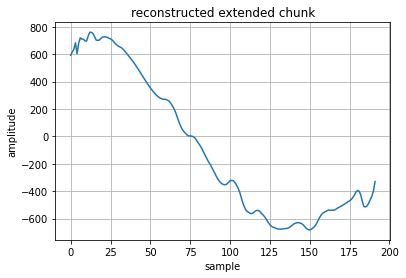

In [27]:
plot(rextended_chunk, "sample", "amplitude", "reconstructed extended chunk", "-")

### Extract the chunk from the extended chunk (with overlaping)

In [28]:
rchunk = rextended_chunk[number_of_overlaped_samples : chunk_size + number_of_overlaped_samples]

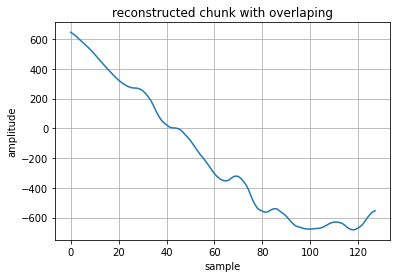

In [29]:
plot(rchunk, "sample", "amplitude", "reconstructed chunk with overlaping", '-')

### The transformed and quantized (non extended) chunk (without overlaping)

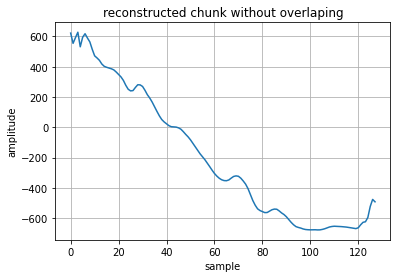

In [30]:
plot(rchunk_center, "sample", "amplitude", "reconstructed chunk without overlaping", '-')